In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st
from pyiga import algebra_cy, ieti_cy
import math

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


ImportError: /home/wolfman/miniconda3/lib/python3.12/site-packages/pyiga-0.1.0-py3.12-linux-x86_64.egg/pyiga/fast_assemble_cy.cpython-312-x86_64-linux-gnu.so: undefined symbol: _Z16fast_assemble_2dPFdmmPvES_mimidiiiiRSt6vectorImSaImEES5_RS2_IdSaIdEE

In [19]:
patch1 = geometry.Quad(np.array([[0,1/3,0,1/3],[1/4,1/4,1/2,1/2]]))
patch2 = geometry.Quad(np.array([[1/3,1,1/3,1],[1/4,1/4,1/2,1/2]]))
patch3 = geometry.Quad(np.array([[0,2/3,0,2/3],[0,0,1/4,1/4]]))
patch4 = geometry.Quad(np.array([[2/3,1,2/3,1],[0,0,1/4,1/4]]))

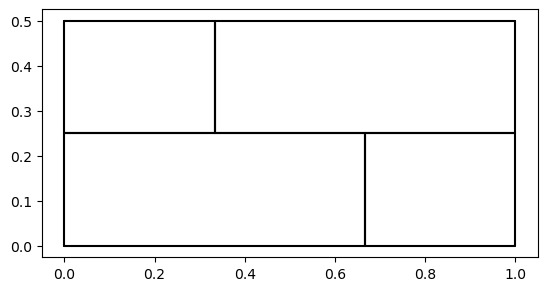

In [21]:
vis.plot_geo(patch1,grid=2)
vis.plot_geo(patch2,grid=2)
vis.plot_geo(patch3,grid=2)
vis.plot_geo(patch4,grid=2)
axis('scaled');

In [69]:
kv = 2*(bspline.make_knots(1,0,1,2),)
M = topology.PatchMesh()
M.add_patch((kv,patch1))
M.add_patch((kv,patch2))
M.add_patch((kv,patch3))
M.add_patch((kv,patch4))

In [70]:
M.set_domain_id({0:{0,1,2,3}})

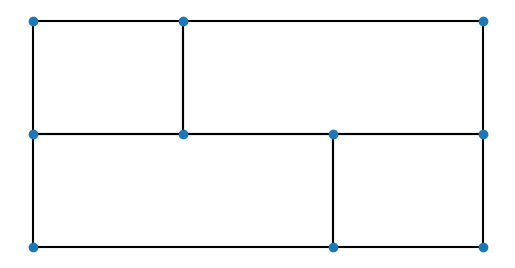

In [71]:
M.draw(nodes=1, patch_idx =0)
axis('off');
plt.savefig("nonadmissible.pdf", format="pdf", bbox_inches="tight")

In [72]:
M.split_patch(2, axis=1)

(2, 4)

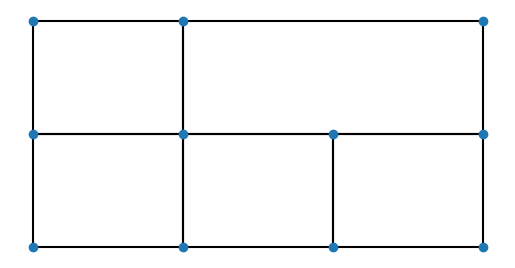

In [73]:
M.draw(nodes=1, patch_idx =0)
axis('off');
plt.savefig("admissible.pdf", format="pdf", bbox_inches="tight")

In [3]:
kv1 = bspline.make_knots(2,0,1,2)

In [4]:
kv2 = bspline.make_knots(2,0,0.5,4)

In [6]:
bspline.prolongation(kv1,kv2).A

array([[1.000, 0.000, 0.000, 0.000],
       [0.750, 0.250, 0.000, 0.000],
       [0.375, 0.563, 0.063, 0.000],
       [0.125, 0.688, 0.188, 0.000],
       [0.000, 0.625, 0.375, 0.000],
       [0.000, 0.500, 0.500, 0.000]])

In [18]:
deg=3

for i in range(8):
    N = 2**(i+1)
    f = lambda x,y : 1.
    g = lambda x,y : 0.
    M = topology.PatchMesh(patches = [(2*(bspline.make_knots(deg,0,1,N),),geometry.unit_square())])
    MP = assemble.Multipatch(M, automatch=True)
    #MP.set_dirichlet_boundary({0:g})
    Kh = MP.assemble_volume('(inner(grad(u),grad(v)) + u*v) * dx', arity=2)
    fh = MP.assemble_volume(vform.L2functional_vf(2), f=f)
    #bcs = MP.compute_dirichlet_bcs({0:g})
    #LS = assemble.RestrictedLinearSystem(Kh,fh,bcs)
    P = scipy.sparse.spdiags([1/Kh.diagonal()],[0])
    #u, it, _, _, res = solvers.pcg(Kh, fh, P = P,rtol = 1e-6, maxiter=30000, output=1)
    
    #print(min_eig, max_eig)

setting up constraints took 3.0994415283203125e-06 seconds.
Basis setup took 0.0013132095336914062 seconds
setting up constraints took 2.384185791015625e-06 seconds.
Basis setup took 0.0005152225494384766 seconds
setting up constraints took 2.1457672119140625e-06 seconds.
Basis setup took 0.000469207763671875 seconds
setting up constraints took 1.6689300537109375e-06 seconds.
Basis setup took 0.0005013942718505859 seconds
setting up constraints took 2.384185791015625e-06 seconds.
Basis setup took 0.0005443096160888672 seconds
setting up constraints took 2.1457672119140625e-06 seconds.
Basis setup took 0.0006566047668457031 seconds
setting up constraints took 2.1457672119140625e-06 seconds.
Basis setup took 0.0012285709381103516 seconds
setting up constraints took 2.384185791015625e-06 seconds.
Basis setup took 0.0034203529357910156 seconds


In [70]:
deg=3
N = 10
f = lambda x,y : 1.
g = lambda x,y : 0.
M = topology.PatchMesh(patches = [(2*(bspline.make_knots(deg,0,1,N),),geometry.unit_square())])
MP = assemble.Multipatch(M, automatch=True)
#MP.set_dirichlet_boundary({0:g})
Kh = MP.assemble_volume('(inner(grad(u),grad(v)) + u*v) * dx', arity=2)
fh = MP.assemble_volume(vform.L2functional_vf(2), f=f)

setting up constraints took 4.291534423828125e-06 seconds.
Basis setup took 0.0014383792877197266 seconds


In [95]:
u, it, min_eig, max_eig, r = solvers.pcg(Kh, fh, x0=None, maxiter=20000, P=1, output=1, rtol=1e-8, atol=1e-12)

pcg with preconditioned condition number κ ~ 148776.77337950724 stopped after 1470 iterations with relres 9.798325374094462e-09


In [106]:
np.sort(np.linalg.eigvals(Kh.A))

array([0.006, 0.048, 0.048, 0.053, 0.062, 0.062, 0.071, 0.072, 0.093, 0.096, 0.110, 0.110, 0.140, 0.140, 0.144, 0.150, 0.156, 0.156, 0.157, 0.162, 0.165, 0.165, 0.171, 0.171, 0.173, 0.183, 0.183, 0.184, 0.188, 0.195, 0.197, 0.214, 0.214, 0.233, 0.233, 0.239, 0.239, 0.252, 0.257, 0.258, 0.265, 0.274, 0.274, 0.282, 0.283, 0.290, 0.301, 0.301, 0.318, 0.320, 0.321, 0.321, 0.340, 0.348, 0.348, 0.350, 0.350, 0.353, 0.353, 0.359, 0.382, 0.383, 0.393, 0.393, 0.406, 0.408, 0.410, 0.410, 0.412, 0.422, 0.423, 0.424, 0.424, 0.433, 0.438, 0.455, 0.465, 0.468, 0.468, 0.482, 0.482, 0.483, 0.483, 0.483, 0.483, 0.512, 0.512, 0.512, 0.522, 0.522, 0.544, 0.544, 0.546, 0.550, 0.581, 0.584, 0.584, 0.591, 0.591, 0.605, 0.605, 0.634, 0.639, 0.644, 0.650, 0.695, 0.695, 0.696, 0.712, 0.712, 0.738, 0.755, 0.756, 0.764, 0.776, 0.827, 0.827, 0.831, 0.831, 0.863, 0.864, 0.879, 0.892, 0.898, 0.906, 0.924, 0.924, 0.947, 0.947, 0.956, 0.956, 0.978, 0.985, 1.011, 1.039, 1.039, 1.040, 1.040, 1.046, 1.050, 1.057, 1.057,

In [97]:
norm(np.linalg.inv(Kh.A))

181.1768351247038

In [108]:
C = np.zeros((1,Kh.shape[0]))
C[0,-1]=1
C[0,-2]=0
C[0,-3]=0
C[0,-4]=0
C[0,-5]=0
b = np.concatenate([fh,np.array([0])])

In [109]:
A = scipy.sparse.bmat([[Kh, C.T],[C, None]])

In [110]:
np.sort(np.linalg.eigvals(A.A))

array([-0.794, 0.008, 0.048, 0.053, 0.055, 0.062, 0.062, 0.072, 0.082, 0.093, 0.096, 0.110, 0.110, 0.140, 0.140, 0.149, 0.151, 0.156, 0.156, 0.158, 0.162, 0.165, 0.165, 0.171, 0.173, 0.182, 0.183, 0.184, 0.188, 0.195, 0.195, 0.197, 0.214, 0.218, 0.233, 0.233, 0.239, 0.239, 0.252, 0.258, 0.258, 0.274, 0.274, 0.274, 0.283, 0.284, 0.290, 0.301, 0.309, 0.318, 0.321, 0.321, 0.330, 0.340, 0.348, 0.348, 0.350, 0.352, 0.353, 0.355, 0.359, 0.382, 0.383, 0.393, 0.398, 0.406, 0.409, 0.410, 0.412, 0.415, 0.422, 0.423, 0.424, 0.424, 0.433, 0.440, 0.457, 0.465, 0.468, 0.471, 0.482, 0.482, 0.483, 0.483, 0.483, 0.483, 0.512, 0.512, 0.522, 0.522, 0.527, 0.544, 0.546, 0.548, 0.551, 0.583, 0.584, 0.589, 0.591, 0.605, 0.605, 0.628, 0.634, 0.639, 0.649, 0.681, 0.695, 0.696, 0.709, 0.712, 0.738, 0.755, 0.756, 0.759, 0.775, 0.824, 0.827, 0.828, 0.831, 0.863, 0.864, 0.879, 0.884, 0.898, 0.905, 0.920, 0.924, 0.946, 0.947, 0.955, 0.956, 0.978, 0.985, 1.006, 1.039, 1.039, 1.040, 1.040, 1.046, 1.050, 1.056, 1.057

In [100]:
norm(np.linalg.inv(A.A))

113.87455151086453

In [101]:
u, it, min_eig, max_eig, r = solvers.pcg(A, b, x0=None, maxiter=20000, P=1, output=1, rtol=1e-8, atol=1e-12)

pcg with preconditioned condition number κ ~ 84504.95998968031 stopped after 2569 iterations with relres 9.980628799115864e-09


In [102]:
norm(u)

7.258101805104371

In [7]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.08373117446899414 seconds.
Basis setup took 0.02042245864868164 seconds


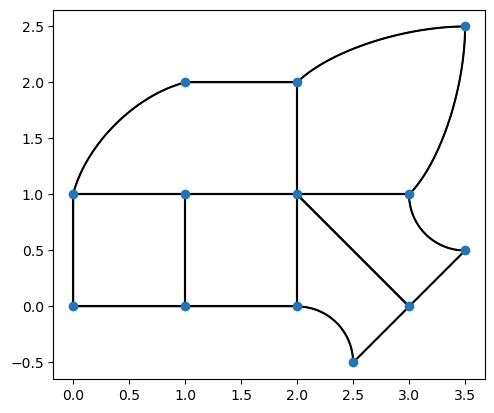

In [3]:
MP.mesh.draw(knots=0, nodes=1, patch_idx=0)

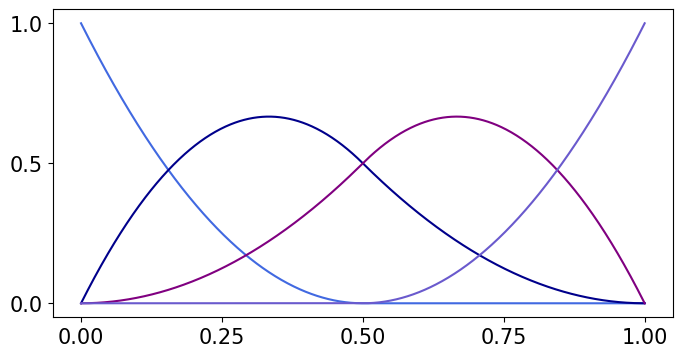

In [4]:
kv1 = bspline.make_knots(2,0.0,1.0,2)
x = np.linspace(0,1,1000)
func1 = [bspline.BSplineFunc(kv1,np.eye(1,kv1.numdofs,i).ravel()) for i in range(kv1.numdofs)]
col1=['royalblue','darkblue','purple','slateblue']
fig = plt.figure(figsize=(8,4))
for i in range(kv1.numdofs):
    plt.plot(x,func1[i](x),color=col1[i])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]),fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
plt.show()

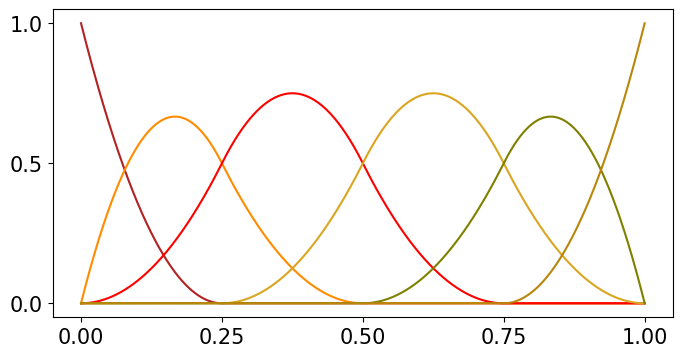

In [5]:
kv2 = bspline.make_knots(2,0.0,1.0,4)
func2 = [bspline.BSplineFunc(kv2,np.eye(1,kv2.numdofs,i).ravel()) for i in range(kv2.numdofs)]
fig = plt.figure(figsize=(8,4))
col2=['firebrick','darkorange','red','goldenrod','olive','darkgoldenrod']
for i in range(kv2.numdofs):
    plt.plot(x,func2[i](x),color=col2[i])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
plt.show()

In [6]:
P = bspline.prolongation(kv1,kv2).tocsc()

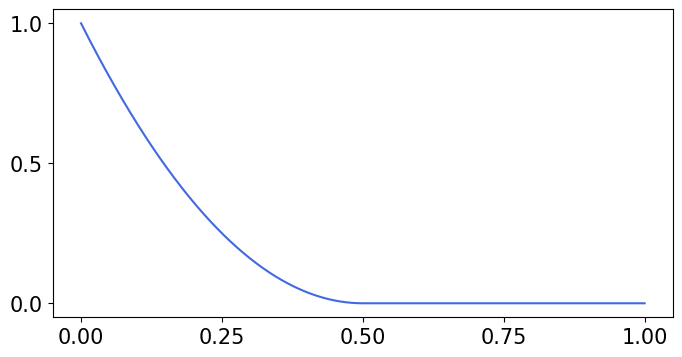

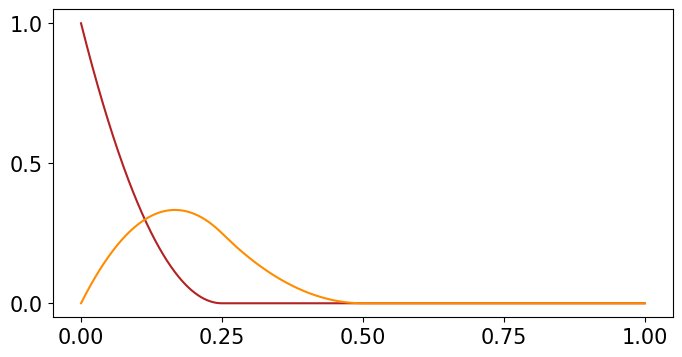

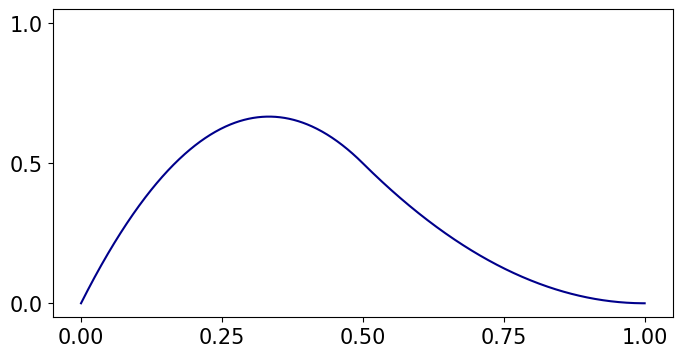

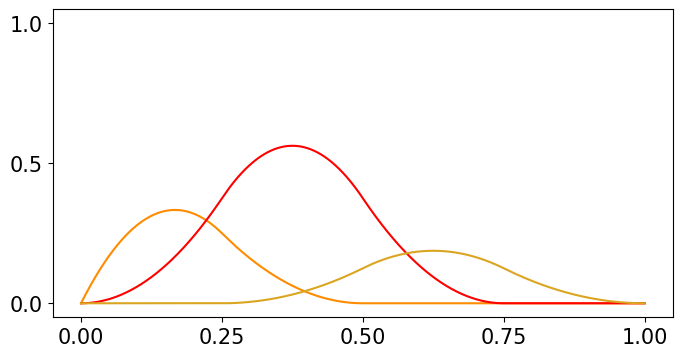

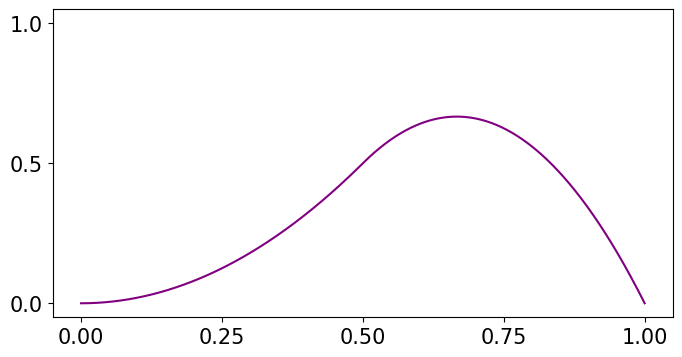

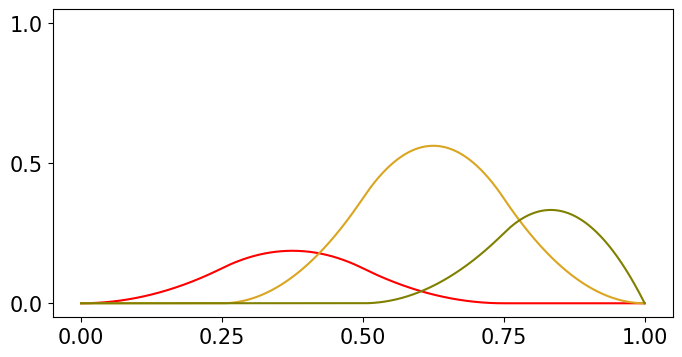

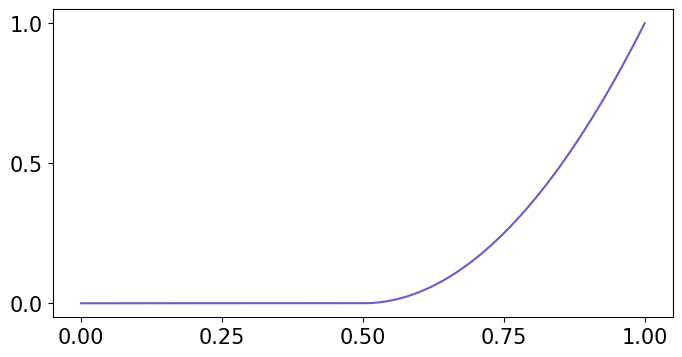

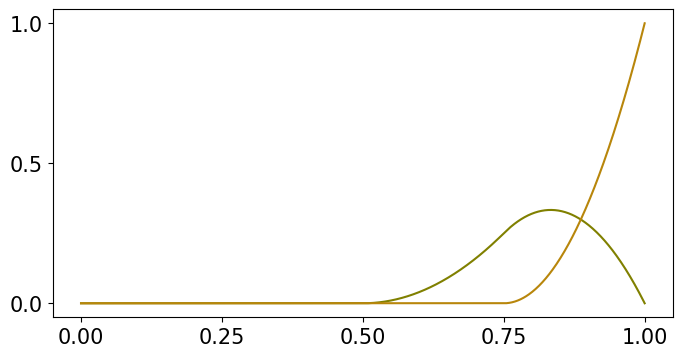

In [7]:
for j in range(P.shape[1]):
    fig = plt.figure(figsize=(8,4))
    plt.plot(x,func1[j](x),color=col1[j])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
    plt.ylim(-0.05,1.05)
    plt.show()
    fig = plt.figure(figsize=(8,4))
    for i in P[:,j].indices:
        plt.plot(x,P[i,j]*func2[i](x),color=col2[i])
        plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
        plt.yticks(np.array([0,0.5,1]),fontsize=15)
        plt.ylim(-0.05,1.05)
    plt.show()

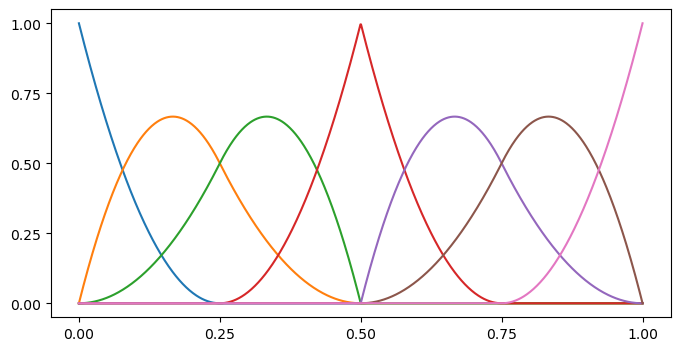

In [8]:
kv3 = bspline.KnotVector(np.array([0,0,0,0.25,0.5,0.5,0.75,1,1,1]),2)
func3 = [bspline.BSplineFunc(kv3,np.eye(1,kv3.numdofs,i).ravel()) for i in range(kv3.numdofs)]
fig = plt.figure(figsize=(8,4))
for i in range(kv3.numdofs):
    plt.plot(x,func3[i](x))
    plt.xticks(np.array([0,0.25,0.5,0.75,1]))
    plt.yticks(np.array([0,0.25,0.5,0.75,1]))
plt.show()

In [9]:
P = bspline.prolongation(kv1,kv3).A

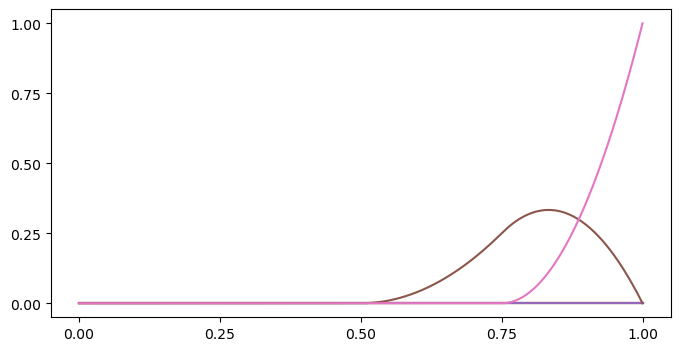

In [10]:
j=3
fig = plt.figure(figsize=(8,4))
for i in range(P.shape[0]):
    plt.plot(x,P[i,j]*func3[i](x))
    plt.xticks(np.array([0,0.25,0.5,0.75,1]))
    plt.yticks(np.array([0,0.25,0.5,0.75,1]))
plt.show()

In [11]:
def drawSkeleton(MP):
    for (p1,b1,_),(p2,b2,_),_ in MP.intfs:
        ax1,sd1=assemble.int_to_bdspec(b1)
        geo=MP.mesh.geos[p1]
        kvs=MP.mesh.kvs[p1]
        grid1=np.linspace(geo.support[(ax1+1)%2][0], geo.support[(ax1+1)%2][1],kvs[(ax1+1)%2].numdofs)
        if (p1,b1) == (4,1) or (p1,b1)==(5,3): grid=grid[1:-1]
        if ax1==0:
            Z = geo.eval(grid1,np.array([geo.support[0][sd1]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd1]]),grid1)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    plt.axis('off');
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs[p], MP.mesh.geos[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)
    plt.axis('off');
    
def drawLocal(MP,ofs):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs[p], MP.mesh.geos[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        for idx in MP.mesh.outer_boundaries:
            if (p,2) not in MP.mesh.outer_boundaries[idx]: gridy[0]+=ofs
            if (p,3) not in MP.mesh.outer_boundaries[idx]: gridy[-1]-=ofs
            if (p,0) not in MP.mesh.outer_boundaries[idx]: gridx[0]+=ofs
            if (p,1) not in MP.mesh.outer_boundaries[idx]: gridx[-1]-=ofs
        Z = geo.eval(gridx,gridy)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='royalblue',s=15,zorder=2)
    plt.axis('off');

In [12]:
deg=2
patches = [(2*(bspline.make_knots(deg,0.0,1.0,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
#M.h_refine({0:0})
#M.h_refine({0:1})
#M.h_refine({1:1})
M.h_refine({0:None});
M.h_refine({0:-1});
#M.h_refine({0:None});
M.h_refine({0:-1});
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.007451295852661133 seconds.
Basis setup took 0.009018659591674805 seconds


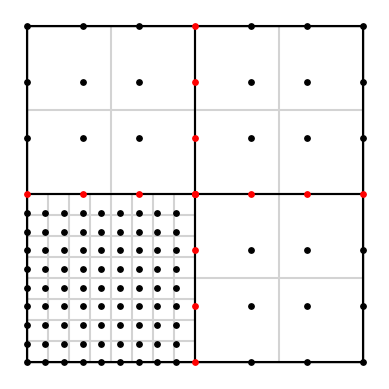

In [13]:
MP.mesh.draw(knots=1,bwidth=1)
#drawLocal(MP)
drawInterior(MP,r=0)
drawSkeleton(MP)
axis('off');
axis('scaled');

In [14]:
patches = [(2*(bspline.make_knots(1,0.0,1.0,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.h_refine({0:None})
M.h_refine({0:-1})
M.h_refine({0:-1})
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.006732463836669922 seconds.
Basis setup took 0.005149364471435547 seconds


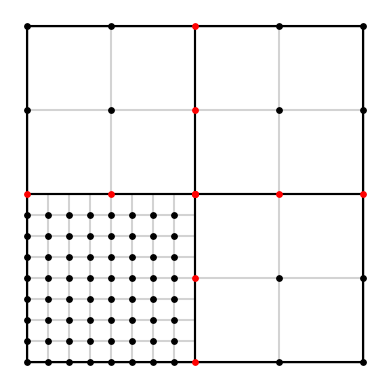

In [15]:
MP.mesh.draw(knots=1)
drawInterior(MP,r=0)
drawSkeleton(MP)

In [71]:
n=4
H, H_inv = algebra.CauchyMatrix(n, return_inv =1)
#H_inv = algebra.HilbertMatrix

In [72]:
H

array([[0.036, 0.083, 0.100, 0.125],
       [0.083, 0.200, 0.250, 0.333],
       [0.100, 0.250, 0.333, 0.500],
       [0.125, 0.333, 0.500, 1.000]])

In [73]:
H_inv@H

array([[1.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 1.000, 0.000],
       [0.000, 0.000, 0.000, 1.000]])

In [74]:
norm(H,1)*norm(H_inv,1)

45511.666666666664

In [75]:
np.linalg.cond(H)

26664.43398212685

In [76]:
_,it,min_eig,max_eig,_ = solvers.pcg(H, np.random.rand(n), maxiter=10000)

In [77]:
max_eig/min_eig

41686.51276675178

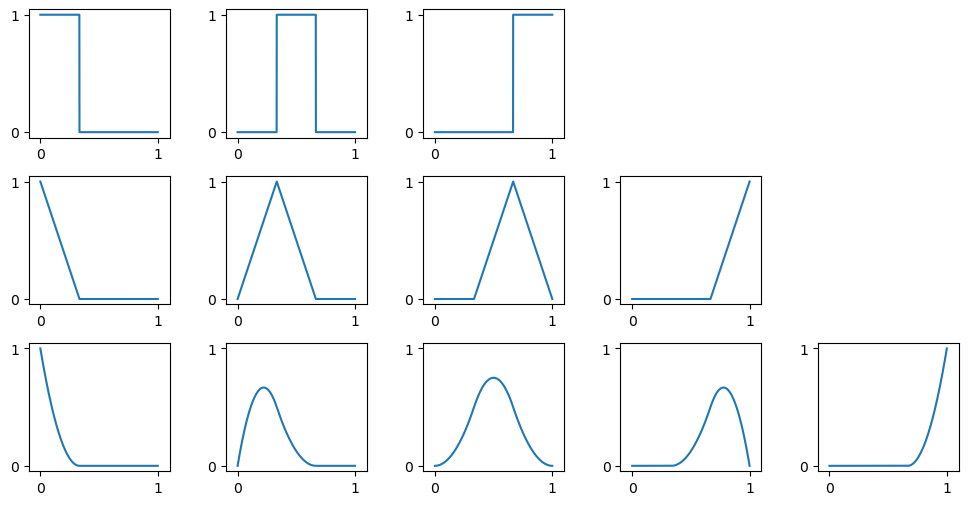

In [63]:
x = np.linspace(0,1,1000)
N = 3
fig = plt.figure(figsize=(12,6));
figs=fig.subplots(3,N + p);
figs[0,-2].axis('off');
figs[0,-1].axis('off');
figs[1,-1].axis('off');
plt.setp(figs, xticks=[0,1], yticks=[0,1]);
plt.subplots_adjust(wspace=0.4,hspace=0.3);
for p in range(3):
    kv=bspline.make_knots(p,0,1,N)
    func = [bspline.BSplineFunc(kv,np.eye(1,kv.numdofs,i).ravel()) for i in range(kv.numdofs)]
    for i in range(N + p):
        if i < N + p:
            figs[p,i].plot(x,func[i](x));
            figs[p,i].axis('equal');
            figs[p,i].set_xlim((-0.1,1.1))
            figs[p,i].set_ylim((-0.1,1.1))
        else:
            figs[p,i].axis('off');
#plt.show();
plt.savefig('Bsplinerecursion.pdf',bbox_inches='tight');

In [51]:
def unit_vec(n,i):
    return np.eye(1,n,i).ravel()

In [8]:
np.eye(1,3,0).ravel()

array([1.000, 0.000, 0.000])

In [2]:
pts=geometry.quarter_annulus().coeffs

In [3]:
pts

array([[[1.000, 0.000, 1.000],
        [2.000, 0.000, 1.000]],

       [[0.707, 0.707, 0.707],
        [1.414, 1.414, 0.707]],

       [[0.000, 1.000, 1.000],
        [0.000, 2.000, 1.000]]])

In [4]:
pts[:,:,:-1]/pts[:,:,-1,None]

array([[[1.000, 0.000],
        [2.000, 0.000]],

       [[1.000, 1.000],
        [2.000, 2.000]],

       [[0.000, 1.000],
        [0.000, 2.000]]])

In [2]:
pts = geometry.quarter_annulus().control_points()

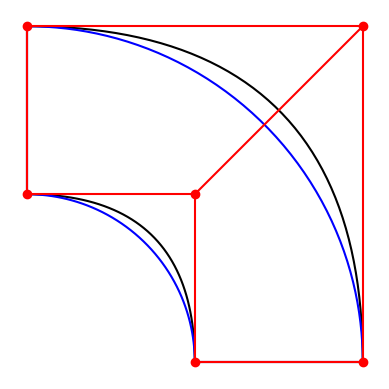

In [163]:
vis.plot_geo(geometry.bspline_quarter_annulus(), grid=2)
vis.plot_geo(geometry.quarter_annulus(), grid=2, bcolor="blue",controlgrid=True)
axis('scaled');
axis('off');
plt.savefig('nurbs.pdf',bbox_inches='tight')

In [6]:
max(1,2)

2

In [49]:
kv = bspline.KnotVector(np.array([0,0,0,0,0.25,0.25,0.5,0.5,0.5,0.75,0.75,1,1,1,1]),3)

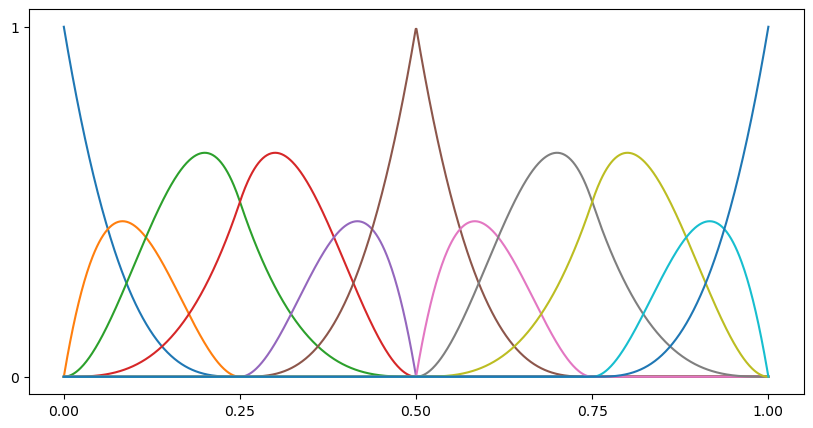

In [61]:
fig = plt.figure(figsize=(10,5))
plt.xticks(kv.mesh)
plt.yticks([0.,1.])
x=np.linspace(0,1,1000)
func = [bspline.BSplineFunc(kv,coeffs=unit_vec(kv.numdofs,i)) for i in range(kv.numdofs)]
for i in range(kv.numdofs):
    plt.plot(x,func[i](x))
plt.savefig('Bsplinesexample.pdf',bbox_inches='tight')

In [68]:
kvs = 2*(bspline.make_knots(2,0,1,2),)

In [69]:
kvs

(KnotVector(array([0.000, 0.000, 0.000, 0.500, 1.000, 1.000, 1.000]), 2),
 KnotVector(array([0.000, 0.000, 0.000, 0.500, 1.000, 1.000, 1.000]), 2))

In [84]:
func = [bspline.BSplineFunc(kvs,coeffs=unit_vec(bspline.numdofs(kvs),i)) for i in range(bspline.numdofs(kvs))]

In [95]:
for i in range(bspline.numdofs(kvs)):
    #vis.plot_field(func[i])
    #axis('scaled');
    #plt.show()

SyntaxError: incomplete input (1154846602.py, line 4)

In [103]:
func[0](x,y)

array([[1.000, 0.960, 0.921, ..., 0.000, 0.000, 0.000],
       [0.960, 0.922, 0.884, ..., 0.000, 0.000, 0.000],
       [0.921, 0.884, 0.848, ..., 0.000, 0.000, 0.000],
       ...,
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000]])

In [108]:
x.shape

(100,)

In [109]:
y.shape

(100,)

In [113]:
X,Y = np.meshgrid(x,y)

In [114]:
X.shape

(100, 100)

In [116]:
func[4](x,y).shape

(100, 100)

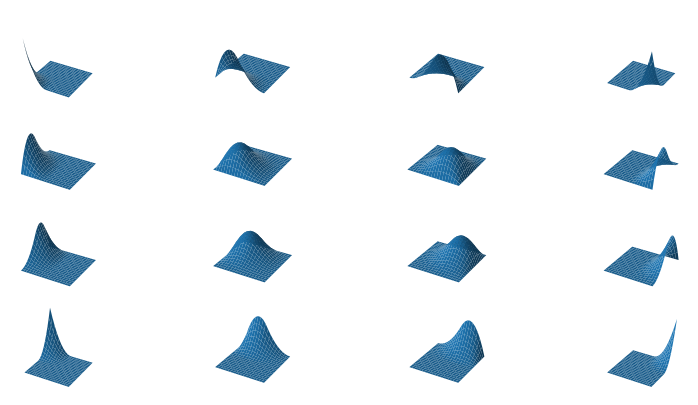

In [161]:
fig = plt.figure(figsize=(10,5));
#figs = fig.subplots(projection='3d')
x = y = np.linspace(0,1,20)
X,Y = np.meshgrid(x,y)
plt.subplots_adjust(wspace=0.01,hspace=0.01);
for i in range(bspline.numdofs(kvs)):
    ax = fig.add_subplot(4,4, i+1, projection = '3d')
    ax.plot_surface(X,Y,func[i](x,y));
    ax.set_axis_off()
    axis('scaled');
plt.savefig('2dBasis.pdf',bbox_inches='tight')